# BioCreative II Gene Mention (GM) Task

For more information: https://biocreative.bioinformatics.udel.edu/tasks/biocreative-ii/task-1a-gene-mention-tagging/

## Training Data

The training data is described in the corpus README.GM file, but I'll describe it here as well. Training data consists of a sentences file `train.in` and a label file `GENE.eval` while lists the offsets of any gene mentions (there may be none for any sentence). It is easiest to understand using an example using the first sentence from `train.in`:

```
P00001606T0076 Comparison with alkaline phosphatases and 5-nucleotidase
```
Each line contains a single sentence, starting with a unique sentence identifier, followed by the text. This particular sample contains two (2) gene mentions, listed on two lines in the `GENE.eval` file:

```
P00001606T0076|14 33|alkaline phosphatases
P00001606T0076|37 50|5-nucleotidase
```
The first field (delimited by the bar symbols) is the matching sentence ID. The second field contains the offset of the first and last characters in the GM, _not counting space characters_. So, looking at _alkaline phosphatases_, the first letter `a` is at offset 14 keeping in mind that the first character in the sentence is offset 0. If you are not careful, you may think the offset of `a` is 16, but remember that spaces are not counted. Counting in a similar way, the last `s` in _phosphatases_ is at offset 33.

## Prepare the training data

The format is not very convenient for training our ML model. One method used to train NER systems to label each sentence token with either 'B','I', or 'O' where 'B' marks the beginning token in an entity, 'I' marks subsequent tokens in a multi-token entity (*inside*), and 'O' is for tokens *outside* the entity.

The module *bc2reader.py* will help convert these two files to something more usable. The first argument to the `BC2Reader` contructor is the sentence file. The second is the gene mention file 


In [48]:
from bc2reader import BC2Reader

train_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2geneMention/train'
reader = BC2Reader('{0}/train.in'.format(train_home), '{0}/GENE.eval'.format(train_home))
reader.convert('{0}/train.json'.format(train_home))
# vocab = [a for a, b in reader.vocab.items() if b >= 3] # Let's see the word at least 3 times
vocab = [a for a, _ in reader.vocab.items()] 

In [49]:
print("Size of vocabulary: {0}".format(len(vocab)))

Size of vocabulary: 36655


This will generate a JSON file with a more familiar format. Here is the first sentence in our BIO format:

In [50]:
import json
with open('{0}/train.json'.format(train_home), 'r') as json_file:
    training_data = json.load(json_file)
    print(training_data[0])

['P00001606T0076', ['Comparison', 'with', 'alkaline', 'phosphatases', 'and', '5-nucleotidase'], ['O', 'O', 'B', 'I', 'O', 'B']]


This may be easier to read if we zip together the tokens and labels:

In [51]:
print(list(zip(training_data[0][1], training_data[0][2])))

[('Comparison', 'O'), ('with', 'O'), ('alkaline', 'B'), ('phosphatases', 'I'), ('and', 'O'), ('5-nucleotidase', 'B')]


## Prepare the test data

In [52]:
test_home = '/home/ryan/Development/deep-learn-bio-nlp/bc2/bc2GNandGMgold_Subs/sourceforgeDistrib-22-Sept-07/genemention/BC2GM/test'
reader = BC2Reader('{0}/test.in'.format(test_home), '{0}/GENE.eval'.format(test_home))
reader.convert('{0}/test.json'.format(test_home))
with open('{0}/test.json'.format(test_home), 'r') as json_file:
    test_data = json.load(json_file)
    print(test_data[0])

['BC2GM000008491', ['Phenotypic', 'analysis', 'demonstrates', 'that', 'trio', 'and', 'Abl', 'cooperate', 'in', 'regulating', 'axon', 'outgrowth', 'in', 'the', 'embryonic', 'central', 'nervous', 'system', '(', 'CNS', ')', '.'], ['O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


## Setup the model constants

In [92]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, Dropout, Bidirectional

max_len = 200
lstm_n = 256
batch_n = 64
epoch_n = 4

word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word2idx['_PAD_'] = 0
word2idx['_OOV_'] = 1
tag2idx = {'O': 0, 'B': 1, 'I': 2}
n_tags = 3

X = [[word2idx.get(m, 1) for m in row[1]] for row in training_data]
y = [[tag2idx.get(m, 1) for m in row[2]] for row in training_data]

X_test = [[word2idx.get(m, 1) for m in row[1]] for row in test_data]
y_test = [[tag2idx.get(m, 1) for m in row[2]] for row in test_data]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['_PAD_'])
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=word2idx['_PAD_'])
 
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"]) 
y = [to_categorical(i, num_classes=3) for i in y]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"]) 
y_test = [to_categorical(i, num_classes=3) for i in y_test]


## Creating the model

In [93]:
# Borrowed heavily from 
# https://appliedmachinelearning.blog/2019/04/01/training-deep-learning-based-named-entity-recognition-from-scratch-disease-extraction-hackathon/
# as a general outline for the model...

input = Input(shape=(max_len,))
 
model = Embedding(input_dim=len(vocab), output_dim=lstm_n, input_length=max_len, mask_zero=True)(input)
model = Bidirectional(LSTM(units=lstm_n, return_sequences=True, recurrent_dropout=0.1))(model)
model = Dropout(0.2)(model)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input, out)
 
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 200, 256)          9383680   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200, 512)          1050624   
_________________________________________________________________
dropout_11 (Dropout)         (None, 200, 512)          0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 200, 3)            1539      
Total params: 10,435,843
Trainable params: 10,435,843
Non-trainable params: 0
_________________________________________________________________


### Review the training history

Train on 13500 samples, validate on 1500 samples
Epoch 1/4
13500/13500 [==============================] - 75s 6ms/step - loss: 0.2672 - acc: 0.9188 - val_loss: 0.1480 - val_acc: 0.9476
Epoch 2/4
13500/13500 [==============================] - 72s 5ms/step - loss: 0.0999 - acc: 0.9631 - val_loss: 0.1288 - val_acc: 0.9536
Epoch 3/4
13500/13500 [==============================] - 73s 5ms/step - loss: 0.0600 - acc: 0.9783 - val_loss: 0.1345 - val_acc: 0.9548
Epoch 4/4
13500/13500 [==============================] - 72s 5ms/step - loss: 0.0401 - acc: 0.9859 - val_loss: 0.1516 - val_acc: 0.9541


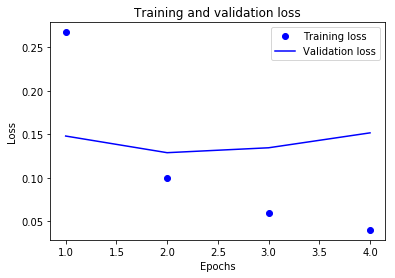

In [94]:
history = model.fit(X, np.array(y), batch_size=batch_n, epochs=epoch_n, validation_split=0.10, verbose=1)

import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test set evaluation

In [95]:
pred = model.predict(X_test)
print(pred.shape)

(5000, 200, 3)


In [96]:
pred_index = np.argmax(pred, axis=-1)
print(pred_index.shape)

(5000, 200)


Now we want to convert back to the original BCII format.

In [97]:
from collections import defaultdict

with open('{0}/ryan_eval.eval'.format(test_home), 'w') as mention_fh:
    for i, row in enumerate(test_data):
        sent_id = row[0]
        tokens = row[1][:max_len]
        running_count = 0
        buffer = {'s':None, 'e':None, 'text':[]}
        for j, token in enumerate(tokens):
            tag = pred_index[i][j]
            if tag == 1:
                buffer.get('text').append(token)
                buffer['s'] = running_count
                buffer['e'] = running_count + len(token) - 1
            elif tag == 2:
                buffer.get('text').append(token)
                buffer['e'] = running_count + len(token) - 1
            elif tag == 0 and buffer.get('s'):
                text = ' '.join(buffer.get('text'))
                mention_fh.write('{0}|{1} {2}|{3}\n'.format(sent_id, buffer.get('s'), buffer.get('e'), text))
                buffer = {'s':None, 'e':None, 'text':[]}
            running_count += len(token)

Using the BCII evaluation script, initial output on the test data is mixed. The precision is in the range of the shared task participants, but the recall leaves something to be desired (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2559986/). The recall tends to have high variance depending on changes to the hyperparameters:

    TP: 3875
    FP: 1025
    FN: 2456
    Precision: 0.790816326530612 Recall: 0.612067603854051 F: 0.690054313952453

Next steps...